---
# aCompCor

This notebook aims to streamline the integration of `segmentations` into the `linescanning`-repository so we can create one big dataframe of physiology/aCompCor to be regressed out of the fMRI-signal

Goals

- Implement aCompCor
- Assess effect of aCompCor

In [1]:
from linescanning import utils,prf,dataset,plotting, segmentations
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pRFline import fitting
from scipy import signal
import os
opj = os.path.join

warnings.simplefilter('ignore')
project_dir = os.environ.get("DIR_PROJECTS")
base_dir = os.path.join(project_dir, 'hemifield')
deriv_dir = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = False
np.set_printoptions(precision=3)


/home/gjheij/anaconda3/envs/prfline/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/gjheij/anaconda3/envs/prfline/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [60]:
# Load data
sub         = '003'
ses         = 4
task        = "task-pRF"
run         = [2,5]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "anat")
prf_new     = opj(base_dir, 'derivatives', 'prf', f"sub-{sub}", f"ses-{ses}")
ribbon      = [357,364]

if not os.path.exists(prf_new):
    os.makedirs(prf_new, exist_ok=True)

# aCompCor on unfiltered data (z-score)

aCompCor is always performed on z-score'd data. This z-score'd data can be unfiltered, low-passed/high-bassed or band-passed. I tried different flavors in this notebook and check the fidelity of the timecourses as well as the power spectra

DATASET
Filter set to None, but high_pass=True, setting filter to 'highpass'

SEGMENTATIONS
Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
Target session: ses-4
Foldover: FH
Found 61 voxels for nuisance regression
We're good to go!

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Data used for aCompCor: 'highpass' (5 components)
 Found 2 components with total explained variance of 0.63%
 Data used for percent-change: 'highpass'
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-5_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Data used for aCompCor: 'highpass' (5 components)
 Found 2 components with total explained variance of 0.6%
 Data used for percent-change: 'highp

vox 0     vox 1     vox 2     vox 3     vox 4  \
subject run t                                                           
003     4   0.000   -1.315368 -0.265643  0.309268 -1.595524 -0.438093   
            0.105   -1.377823 -1.912008 -0.978109  0.190209 -2.267791   
            0.210   -1.129942 -0.617976 -0.279602 -0.280491 -1.363508   
            0.315   -0.285226 -0.696286  0.089101  0.932741  0.634738   
            0.420    0.710006 -0.522564  0.324043 -0.354686  0.372347   
...                       ...       ...       ...       ...       ...   
        6   545.475 -0.041410  0.315006 -0.199603 -0.589296 -0.442649   
            545.580 -0.782246  0.338062  0.009508 -0.307170  0.116927   
            545.685  0.212162 -2.219814 -0.220345 -1.249743 -0.956374   
            545.790  0.481493  0.019304  0.715632 -0.324126 -0.445765   
            545.895  0.233267  0.170881  1.106545  1.041730 -0.590437   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     4   0.000   -0.569827 -0.139511 -0.665458 -0.614583 -0.328858  ...   
            0.105   -1.980658  0.255747 -0.667780 -1.378339 -0.277141  ...   
            0.210    0.275759  0.984244 -0.261174 -2.842978 -0.885704  ...   
            0.315   -0.494024  0.134320  2.284329 -0.642966 -0.445554  ...   
            0.420   -0.879452  1.041484 -0.545947  2.156570 -0.293730  ...   
...                       ...       ...       ...       ...       ...  ...   
        6   545.475  1.494913 -0.382900  0.419311 -0.834963  1.187292  ...   
            545.580 -0.595963  1.211990  0.121614  3.506011 -1.304185  ...   
            545.685  0.284119 -0.178048  0.468145 -0.667895 -1.096654  ...   
            545.790  0.950239  1.712666 -0.158115  0.063212 -0.489546  ...   
            545.895  1.237013  0.309367 -0.347813 -1.011778 -0.034549  ...   

                      vox 710   vox 711   vox 712   vox 713   vox 714  \
subject run t                                                           
003     4   0.000    0.601998 -1.130228 -0.077964  1.292172 -1.283327   
            0.105    0.029814 -2.008024  0.674151 -0.644172 -0.625582   
            0.210    0.321121 -0.912780  1.223333 -0.054432  0.278444   
            0.315   -1.189911 -0.263578 -1.410006  0.631533  0.032667   
            0.420   -0.044705  1.786661 -0.447563 -0.449201 -1.617718   
...                       ...       ...       ...       ...       ...   
        6   545.475  1.119618  0.079201  0.877492 -0.235296 -0.862000   
            545.580 -1.346183 -0.161423  3.310539  0.052328 -0.963684   
            545.685  1.201141  0.336731  0.763038  0.749723 -0.277418   
            545.790 -0.752066 -0.250745 -0.806975 -0.828784 -0.363334   
            545.895 -0.450558 -0.442174  2.142706  0.598246 -0.689016   

                      vox 715   vox 716   vox 717   vox 718   vox 719  
subject run t                                                          
003     4   0.000   -0.657003  0.705012  0.529301  1.997395  0.039915  
            0.105    0.409221 -0.203537  0.927640 -1.263470 -0.049854  
            0.210    0.842379 -0.359450  0.585430  0.457340 -0.331013  
            0.315   -1.702549 -0.905044  2.211564 -0.867394  1.685087  
            0.420    0.418492  0.924249  0.164521  1.133643  1.507306  
...                       ...       ...       ...       ...       ...  
        6   545.475 -0.655034  0.176279  1.007918 -0.954781  0.013786  
            545.580 -0.363311  0.400285  0.003192 -1.637476 -0.189634  
            545.685  1.640942  0.088700 -0.757494 -0.508731  0.124602  
            545.790  0.687439 -0.369606  0.328894 -1.874762 -1.191330  
            545.895 -0.234854  1.159578  0.623725  1.318948 -0.847100  

[15600 rows x 720 columns]

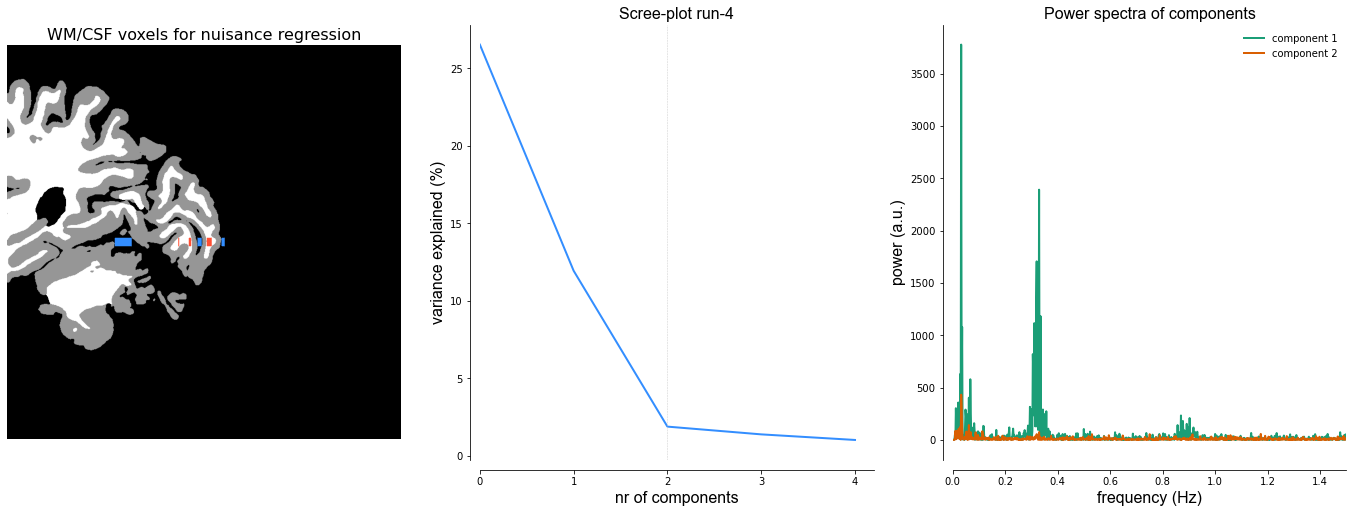

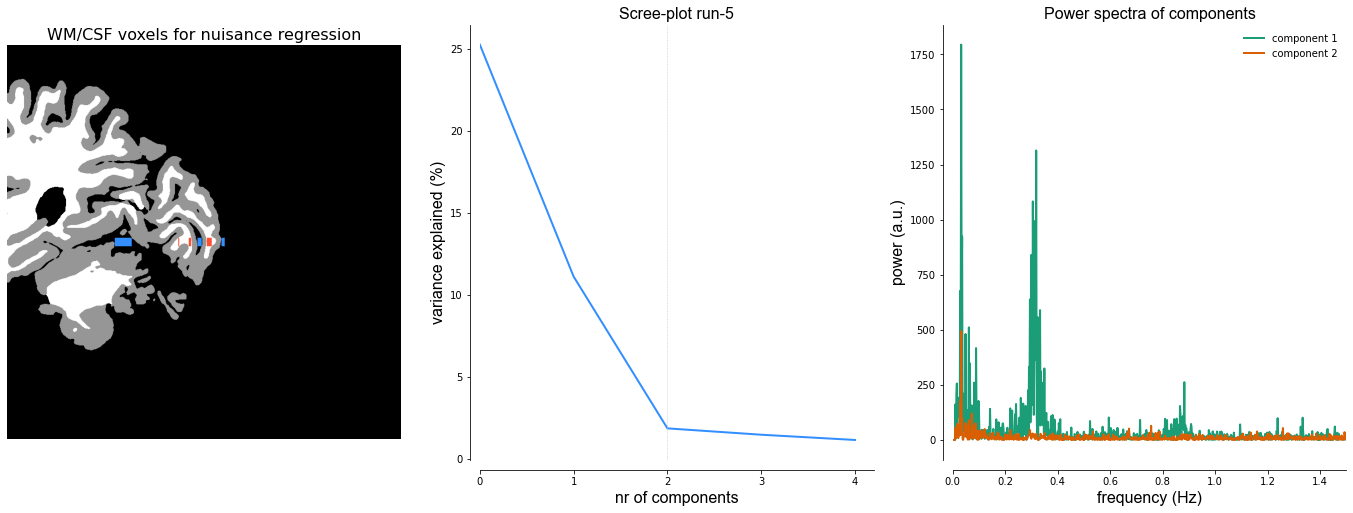

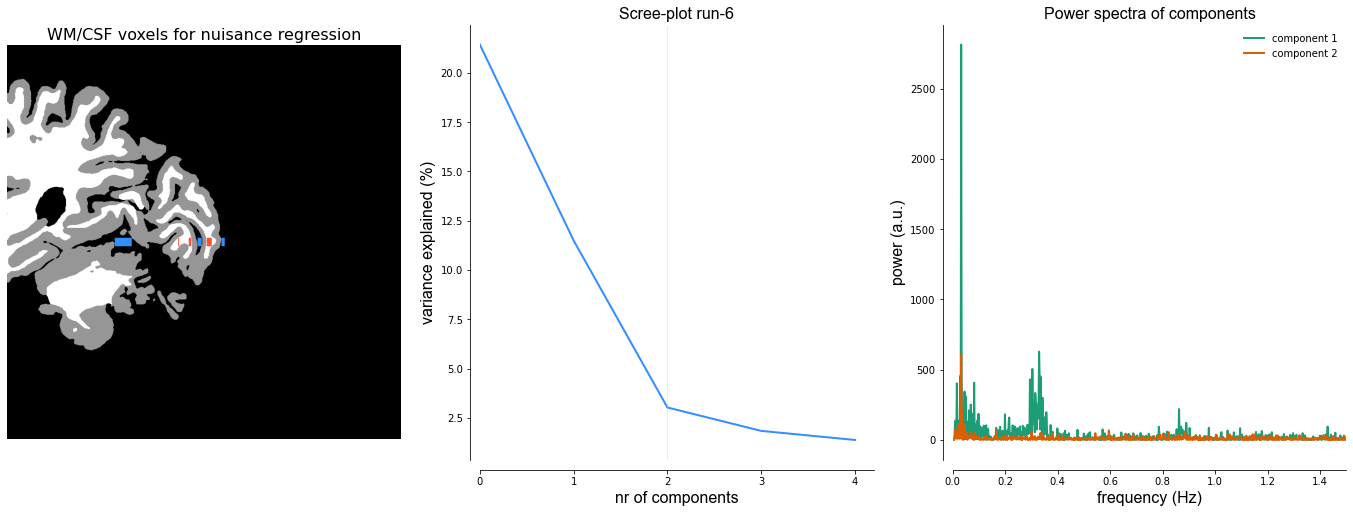

In [7]:
run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir, exclude="run-2")
func_file   = utils.get_file_from_substring("bold.mat", run_files)
ref = "/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/anat/sub-003_ses-4_acq-1slice_run-2_T1w.nii.gz"

window = 19
order = 3

func = dataset.Dataset(func_file,
                       deleted_first_timepoints=0, 
                       deleted_last_timepoints=0,
                       window_size=window, # needs to be odd
                       high_pass=True,
                       low_pass=False,
                       poly_order=order,
                       use_bids=True,
                       verbose=True,
                       acompcor=True,
                       ref_slice=ref,
                       n_pca=5)

data = func.fetch_fmri(dtype="acompcor")
data


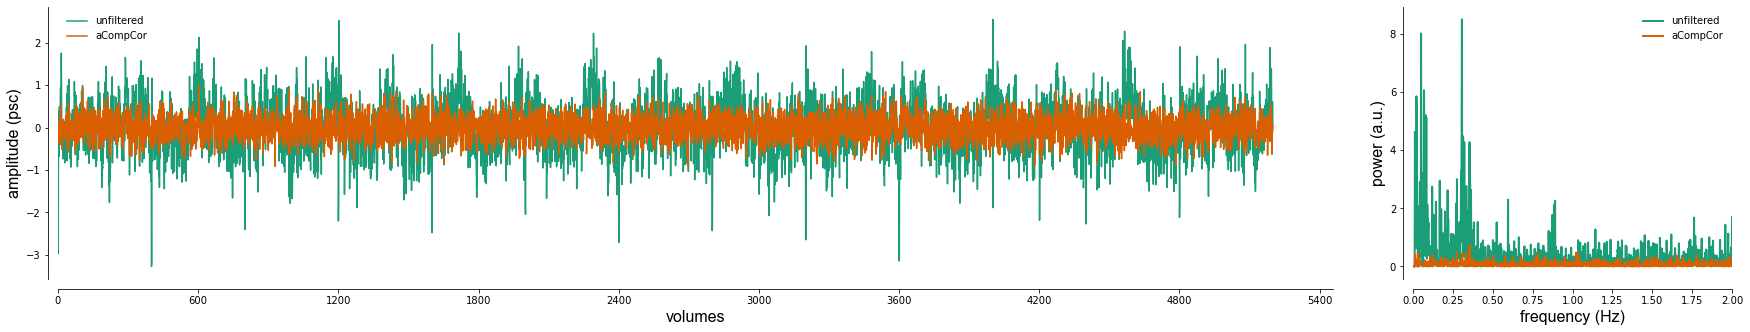

In [4]:
# timecourse
tc1 = func.df_func_zscore.groupby(['subject', 't']).mean()['vox 359'].values
tc2 = func.df_func_acomp.groupby(['subject', 't']).mean()['vox 359'].values

freq_type = "fft"
labels = ['unfiltered', 'aCompCor']
clipper = 10

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2], 
                  labels=labels, 
                  color=["#1B9E77","#D95F02"],
                  x_label="volumes",
                  y_label="amplitude (psc)",                   
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
freq1 = func.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=clipper)
freq2 = func.get_freq(
    tc2, TR=0.105, spectrum_type=freq_type, clip_power=clipper)

plotting.LazyPlot([freq1[1],freq2[1]],
                  xx=freq2[0],
                  color=["#1B9E77","#D95F02"], 
                  labels=labels, 
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,2],
                  line_width=2)


Seems to get rid of some stuff, at least..

# pRF-data; aCompCor on DCT-filtered data

Below I try literally the same procedure as above, but this time we also average across runs and iterations of the experiment. First, a simple high-pass example:

DATASET
Filter set to None, but high_pass=True, setting filter to 'highpass'

SEGMENTATIONS
Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
Target session: ses-4
Foldover: FH
Found 61 voxels for nuisance regression
We're good to go!

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Data used for aCompCor: 'highpass' (60 components)
 Found 3 components with total explained variance of 0.66%
 Data used for percent-change: 'highpass'
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-5_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Data used for aCompCor: 'highpass' (60 components)
 Found 2 components with total explained variance of 0.6%
 Data used for percent-change: 'hig

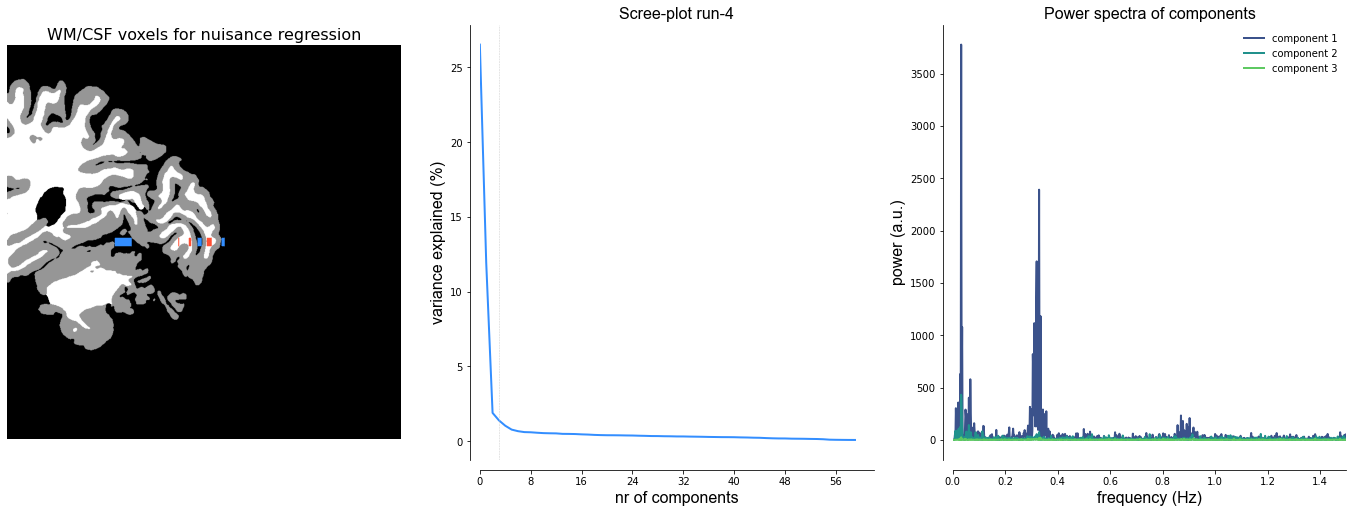

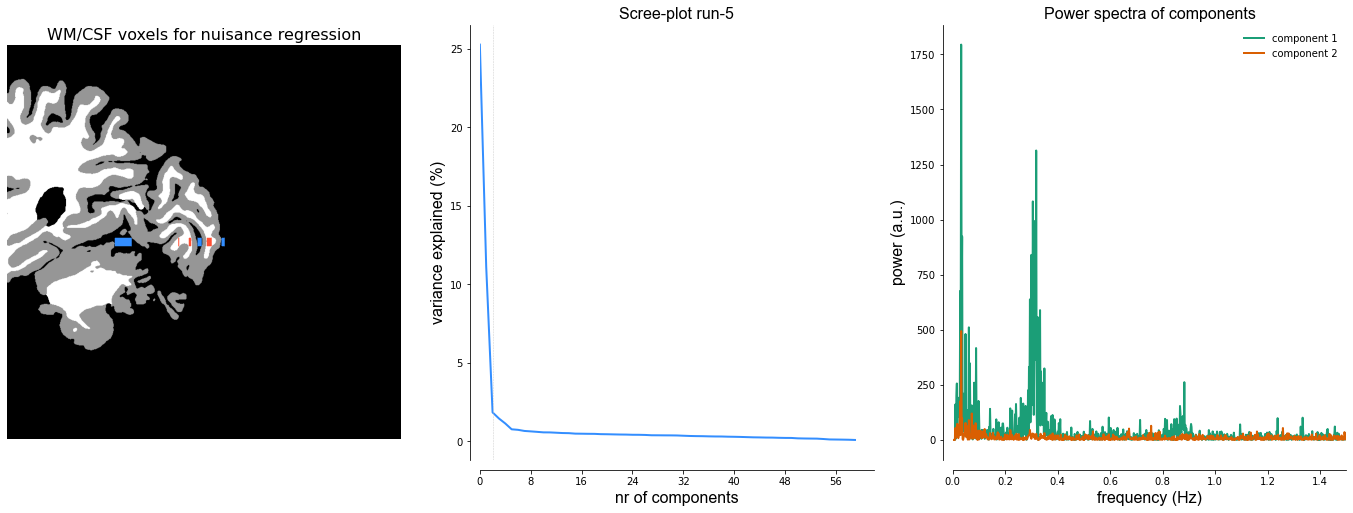

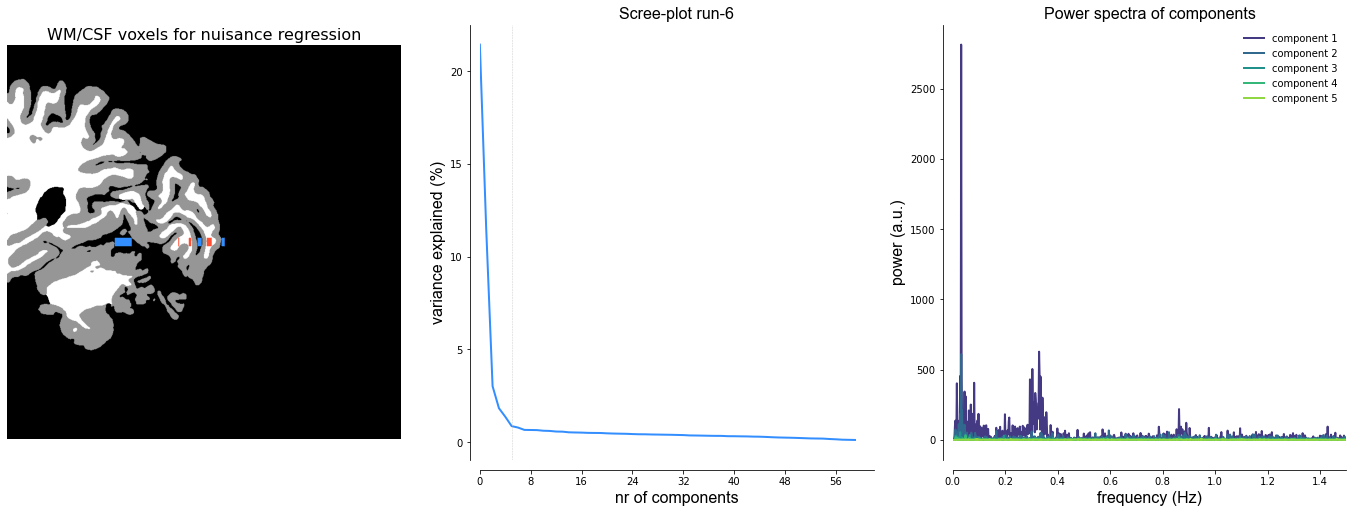

In [71]:
func_files = utils.get_file_from_substring(["task-pRF", "bold.mat"], func_dir, exclude="run-2")
# log_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sourcedata/sub-003/ses-4/sub-003_ses-4_task-pRF_run-imgs"
log_dir = "/mnt/d/FSL/shared/spinoza/programs/project_repos/LineExps/lineprf/logs/sub-003_ses-0_task-pRF_run-imgs"

line_hp = fitting.FitLines(func_files=func_files,
                            TR=0.105,
                            low_pass=False,
                            high_pass=True,
                            window_size=19,
                            poly_order=3,
                            log_dir=log_dir,
                            stage='grid+iter',
                            model='norm',
                            baseline_duration=20,
                            iter_duration=240,
                            n_iterations=2,
                            verbose=True,
                            ribbon=ribbon,
                            fmri_output="acompcor",
                            acompcor=True,
                            ref_slice=ref,
                            n_pca=60)


In [36]:
line_hp.prepare_design()

Using /mnt/d/FSL/shared/spinoza/programs/project_repos/LineExps/lineprf/logs/sub-003_ses-0_task-pRF_run-imgs for design

EYETRACKER
 No eyetracking data used

EXPTOOLS
 1st 't' @4.2s
 Cutting 4.2s from onsets
TR = 0 		(@0.0s| trial=0) 	img=sub-003_ses-0_task-pRF_run-imgs_Screenshots0000.png
TR = 1 		(@0.1s| trial=0) 	img=sub-003_ses-0_task-pRF_run-imgs_Screenshots0000.png
TR = 2 		(@0.21s| trial=1) 	img=sub-003_ses-0_task-pRF_run-imgs_Screenshots0001.png
TR = 3 		(@0.32s| trial=1) 	img=sub-003_ses-0_task-pRF_run-imgs_Screenshots0001.png
TR = 4 		(@0.42s| trial=2) 	img=sub-003_ses-0_task-pRF_run-imgs_Screenshots0002.png
TR = 5 		(@0.53s| trial=2) 	img=sub-003_ses-0_task-pRF_run-imgs_Screenshots0002.png
TR = 6 		(@0.63s| trial=2) 	img=sub-003_ses-0_task-pRF_run-imgs_Screenshots0002.png
TR = 7 		(@0.73s| trial=3) 	img=sub-003_ses-0_task-pRF_run-imgs_Screenshots0003.png
TR = 8 		(@0.84s| trial=3) 	img=sub-003_ses-0_task-pRF_run-imgs_Screenshots0003.png
TR = 9 		(@0.94s| trial=4) 	img=sub-0

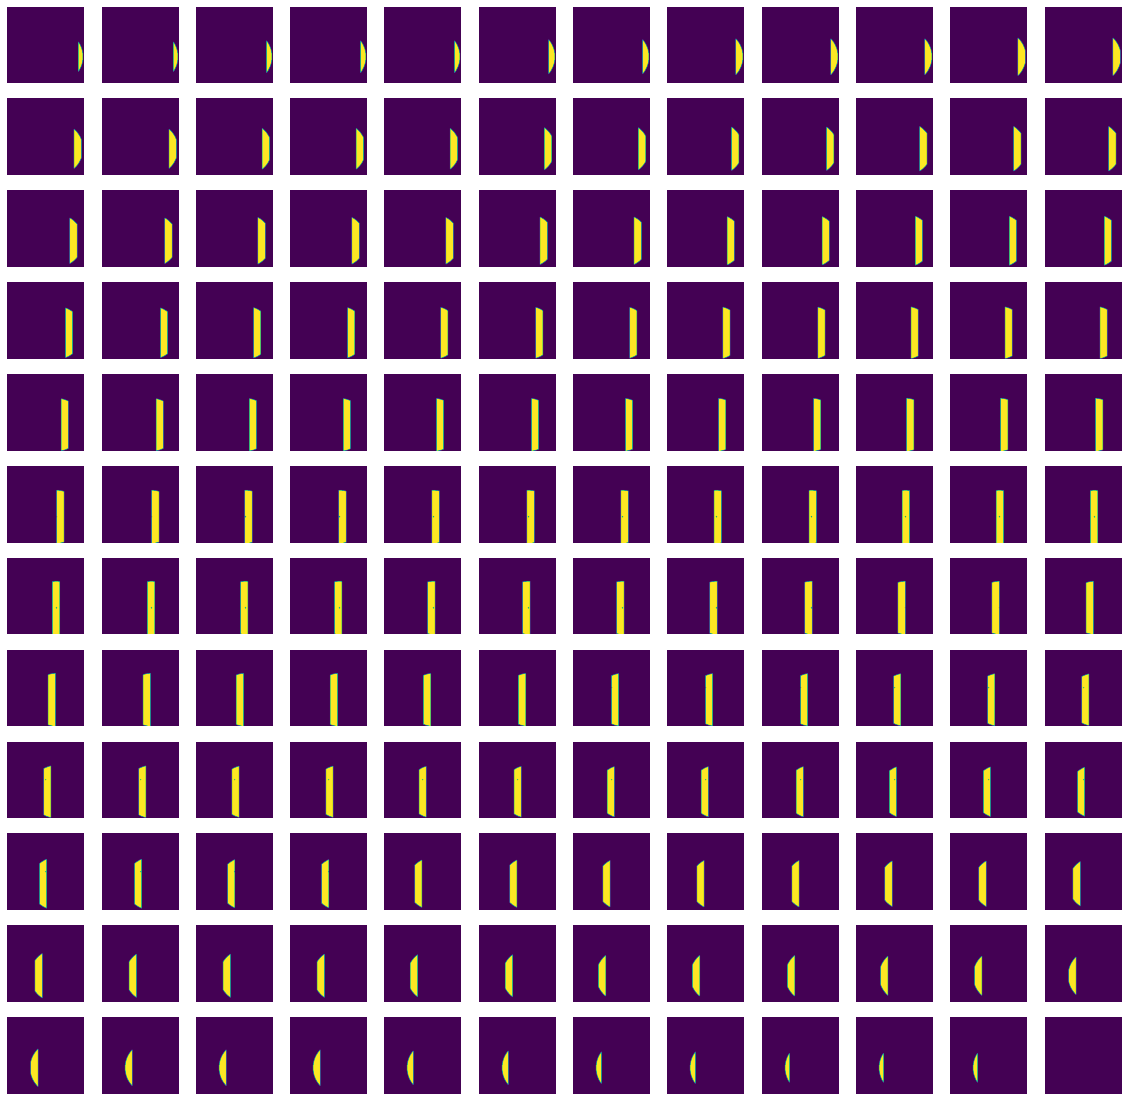

In [54]:
fig,axs = plt.subplots(12,12, figsize=(20,20))

start = 2190
for i, ax in enumerate(fig.axes):
    ax.imshow(line_hp.design[..., start])
    ax.axis('off')
    start += 1
plt.show()


In [55]:
cut = line_hp.design[...,190:]
cut.shape

(270, 270, 2286)

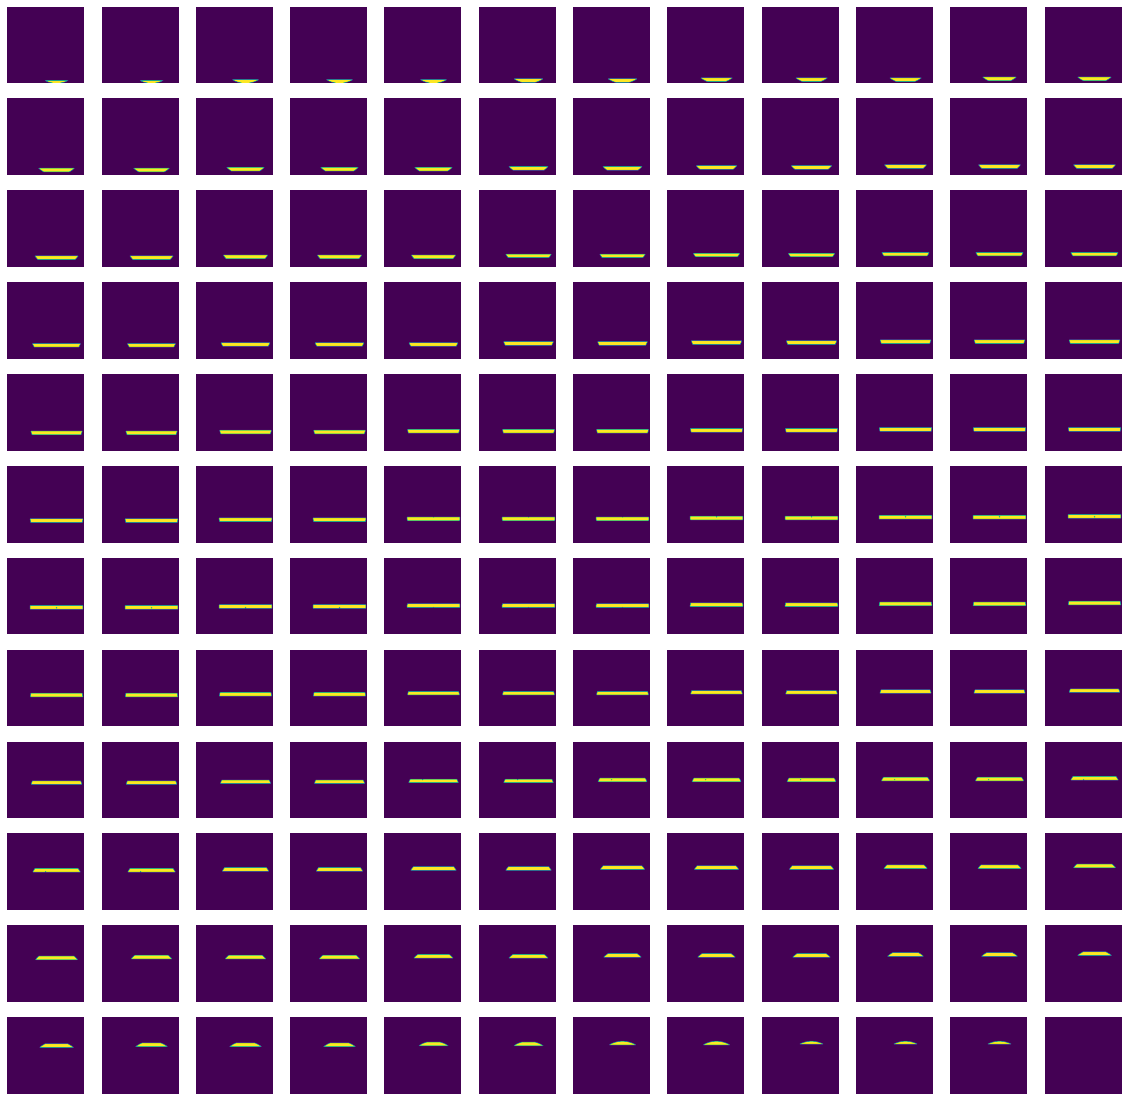

In [58]:
fig,axs = plt.subplots(12,12, figsize=(20,20))

start = 0
for i, ax in enumerate(fig.axes):
    ax.imshow(cut[..., start])
    ax.axis('off')
    start += 1
plt.show()


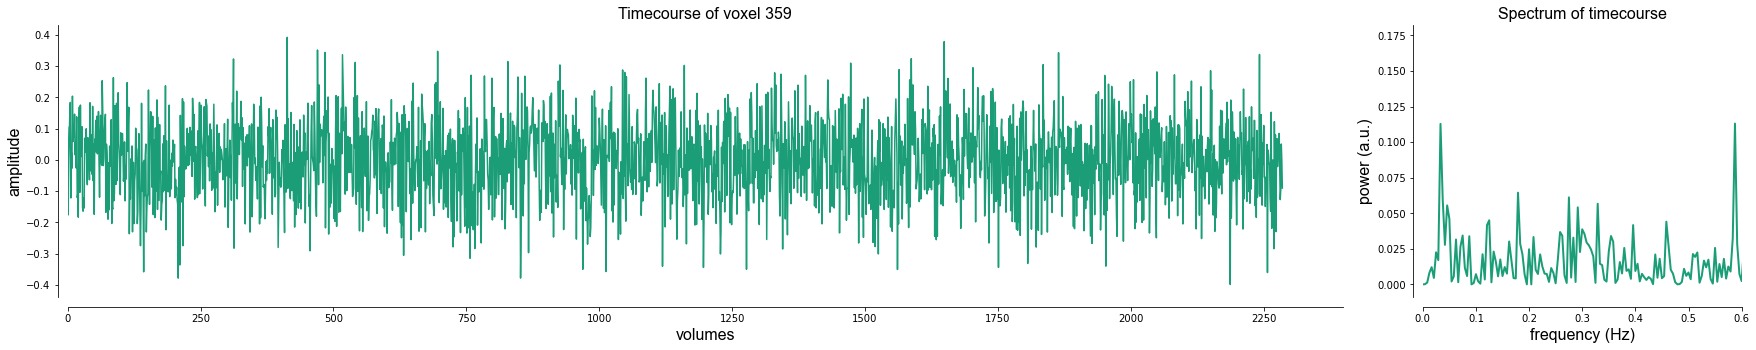

In [72]:
freq_type = "fft"
clipper = 5
tc1 = line_hp.avg_iters_no_baseline.mean(axis=-1)

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot(tc1, 
                  color="#1B9E77",
                  x_label="volumes",
                  y_label="amplitude",
                  title="Timecourse of voxel 359",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
tc1_freq = line_hp.get_freq(tc1, TR=0.105, spectrum_type=freq_type) #, clip_power=clipper)

plotting.LazyPlot(tc1_freq[1],
                  xx=tc1_freq[0],
                  color="#1B9E77",
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,0.6],
                  line_width=2)


Still quite noisy, low z-score values

# pRF-data; aCompCor on DCT-filtered+SG-filtered data

Now what I've tried before: high-pass filtering with DCT-set and low-pass filtering with Savitsky-Golay filter:

DATASET
Filter set to None, but low_pass+high_pass=True, setting filter to 'lowpass'

SEGMENTATIONS
Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
Target session: ses-4
Foldover: FH
Found 61 voxels for nuisance regression
We're good to go!

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 19, order = 3)
 Data used for aCompCor: 'lowpass' (5 components)
 Found 1 components with total explained variance of 0.7%
 Data used for percent-change: 'lowpass'
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-5_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] 

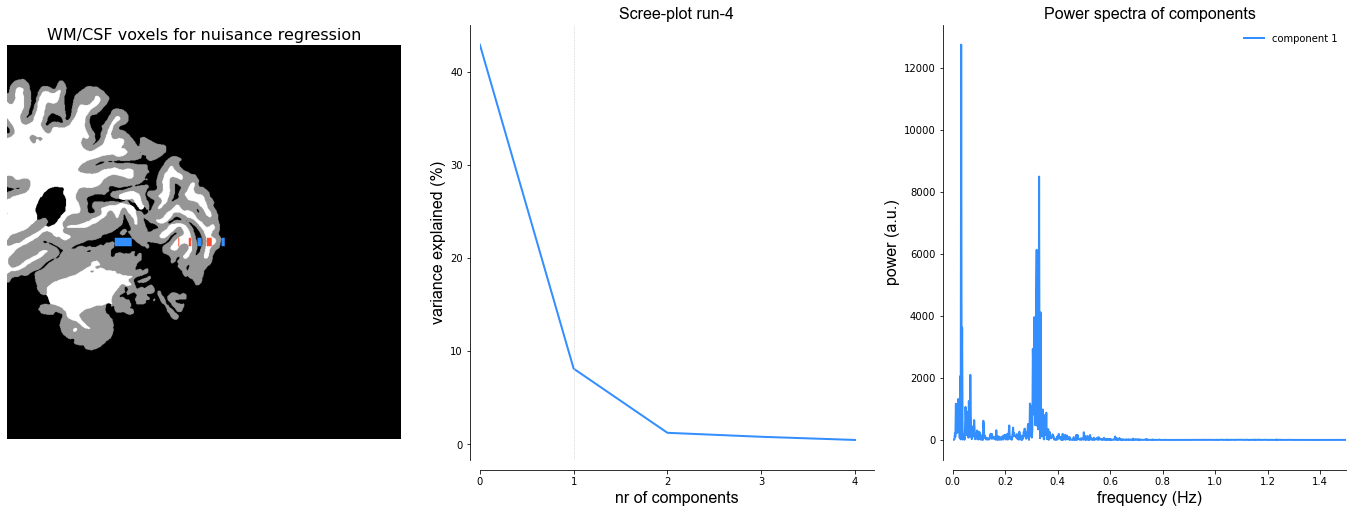

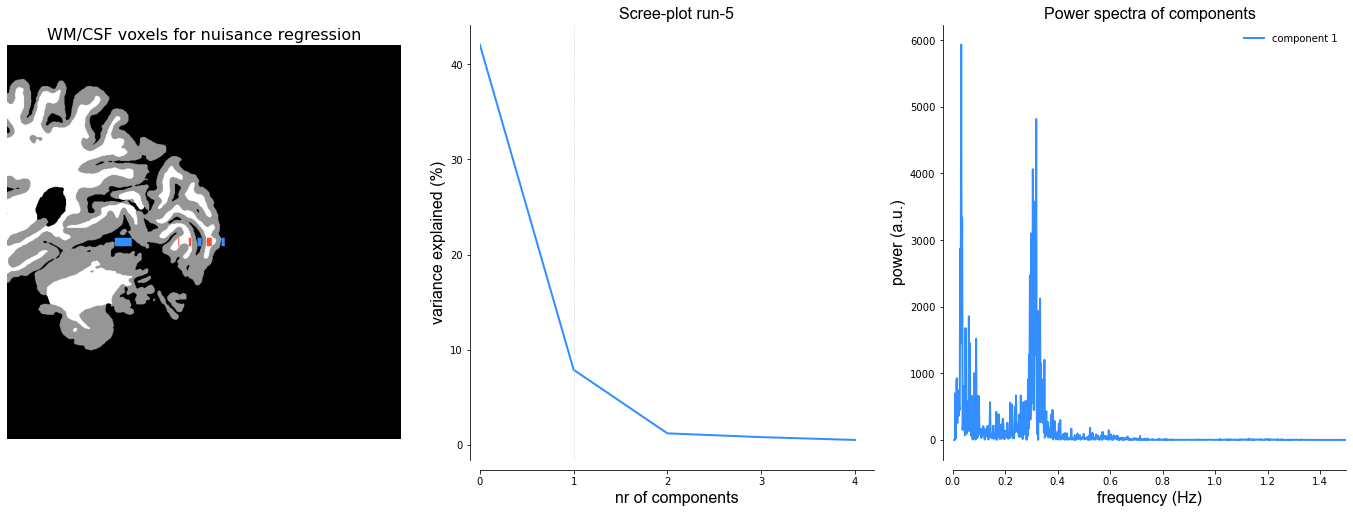

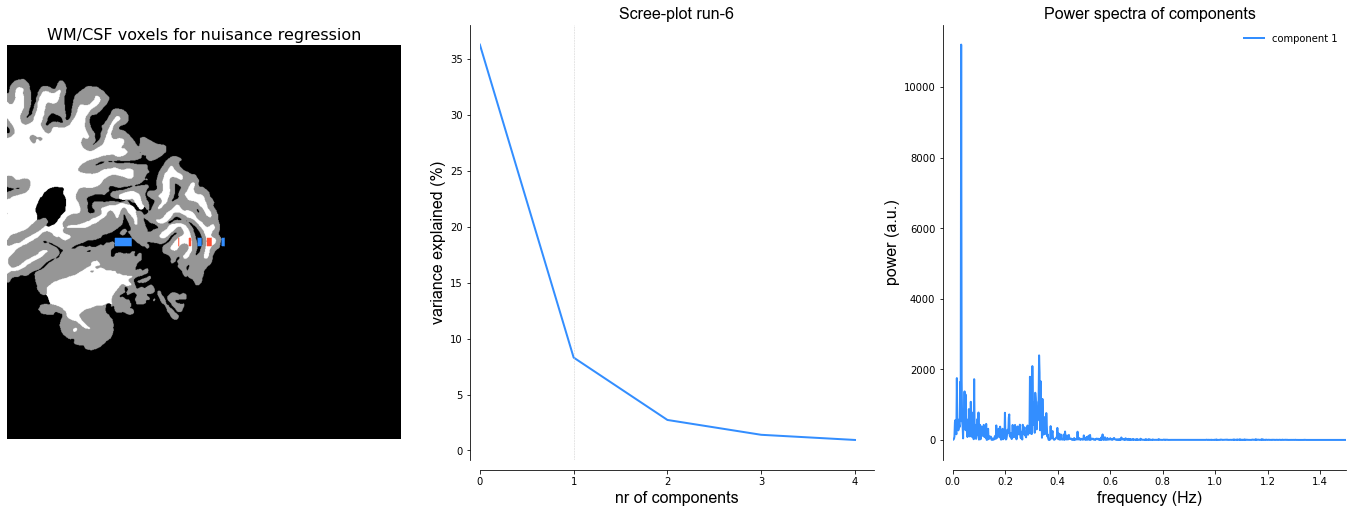

In [67]:
line_hplp = fitting.FitLines(func_files=func_files,
                            TR=0.105,
                            low_pass=True,
                            high_pass=True,
                            window_size=19,
                            poly_order=3,
                            log_dir=log_dir,
                            stage='grid+iter',
                            model='norm',
                            baseline_duration=20,
                            iter_duration=240,
                            n_iterations=2,
                            verbose=True,
                            ribbon=ribbon,
                            fmri_output="acompcor",
                            acompcor=True,
                            ref_slice=ref)

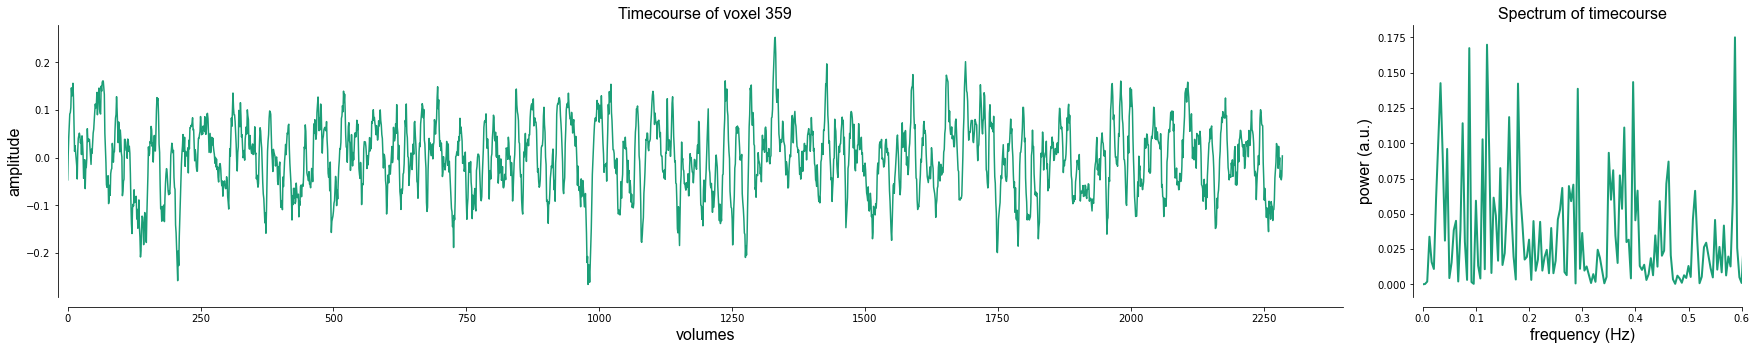

In [68]:
freq_type = "fft"
clipper = 5
tc1 = line_hplp.avg_iters_no_baseline.mean(axis=-1)

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot(tc1, 
                  color="#1B9E77",
                  x_label="volumes",
                  y_label="amplitude",
                  title="Timecourse of voxel 359",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
tc1_freq = line_hplp.get_freq(tc1, TR=0.105, spectrum_type=freq_type) #, clip_power=clipper)

plotting.LazyPlot(tc1_freq[1],
                  xx=tc1_freq[0],
                  color="#1B9E77",
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,0.6],
                  line_width=2)


Also noisy

# Combined

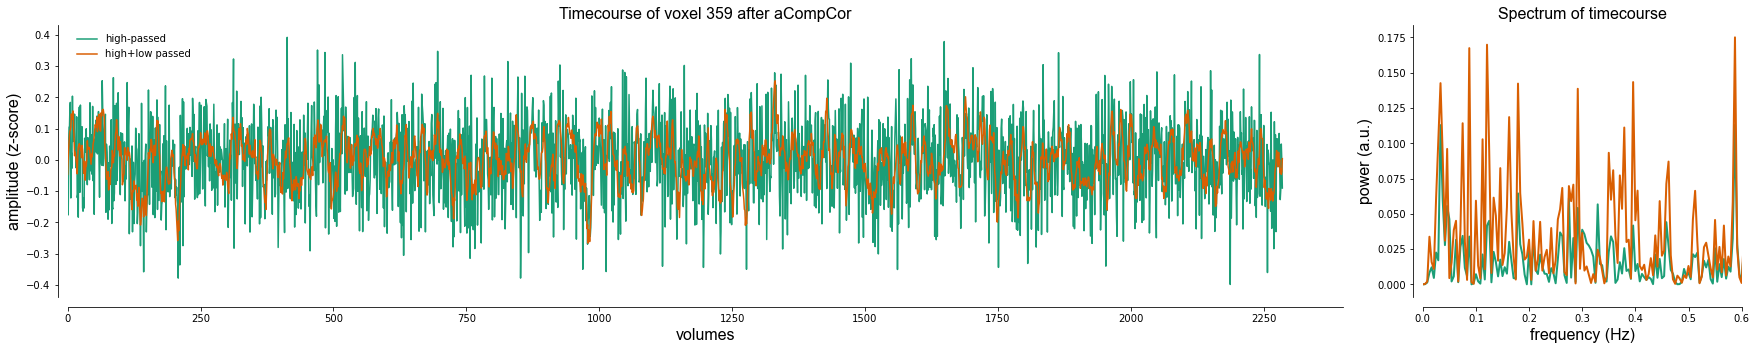

In [73]:
freq_type = "fft"
colors = ["#1B9E77","#D95F02"]
labels = ['high-passed', 'high+low passed']
clipper = 5
tc1 = line_hp.avg_iters_no_baseline.mean(axis=-1)
tc2 = line_hplp.avg_iters_no_baseline.mean(axis=-1)

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1,tc2], 
                  color=colors,
                  x_label="volumes",
                  y_label="amplitude (z-score)",
                  title="Timecourse of voxel 359 after aCompCor",
                  labels=labels,
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
tc1_freq = line_hp.get_freq(tc1, TR=0.105, spectrum_type=freq_type) #, clip_power=clipper)
tc2_freq = line_hplp.get_freq(tc2, TR=0.105, spectrum_type=freq_type) #, clip_power=clipper)

plotting.LazyPlot([tc1_freq[1], tc2_freq[1]],
                  xx=tc1_freq[0],
                  color=colors,
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,0.6],
                  line_width=2)


The timecourses don't seem to be helped too much by aCompCor, let alone the power spectra

# Check if PSC is still valid

Because I messed quite a bit in the code to make it eventually better, I wanted to make sure the percent-signal change process wasn't affected. This indeed seems to be the case, but also different filtering options don't really help too much

In [82]:
line_psc = fitting.FitLines(func_files=func_files,
                            TR=0.105,
                            low_pass=True,
                            high_pass=True,
                            window_size=19,
                            poly_order=3,
                            log_dir=log_dir,
                            stage='grid+iter',
                            model='norm',
                            baseline_duration=20,
                            iter_duration=240,
                            n_iterations=2,
                            verbose=True,
                            ribbon=ribbon,
                            ref_slice=ref)

# heavy filter
line_psc2 = fitting.FitLines(func_files=func_files,
                            TR=0.105,
                            low_pass=True,
                            high_pass=True,
                            window_size=37,
                            poly_order=3,
                            log_dir=log_dir,
                            stage='grid+iter',
                            model='norm',
                            baseline_duration=20,
                            iter_duration=240,
                            n_iterations=2,
                            verbose=True,
                            ribbon=ribbon,
                            ref_slice=ref)

# poly order = 2
line_psc3 = fitting.FitLines(func_files=func_files,
                            TR=0.105,
                            low_pass=True,
                            high_pass=True,
                            window_size=19,
                            poly_order=2,
                            log_dir=log_dir,
                            stage='grid+iter',
                            model='norm',
                            baseline_duration=20,
                            iter_duration=240,
                            n_iterations=2,
                            verbose=True,
                            ribbon=ribbon,
                            ref_slice=ref)                                           

DATASET
Filter set to None, but low_pass+high_pass=True, setting filter to 'lowpass'

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 19, order = 3)
 Data used for percent-change: 'lowpass'
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-5_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 19, order = 3)
 Data used for percent-change: 'lowpass'
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-6_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [r

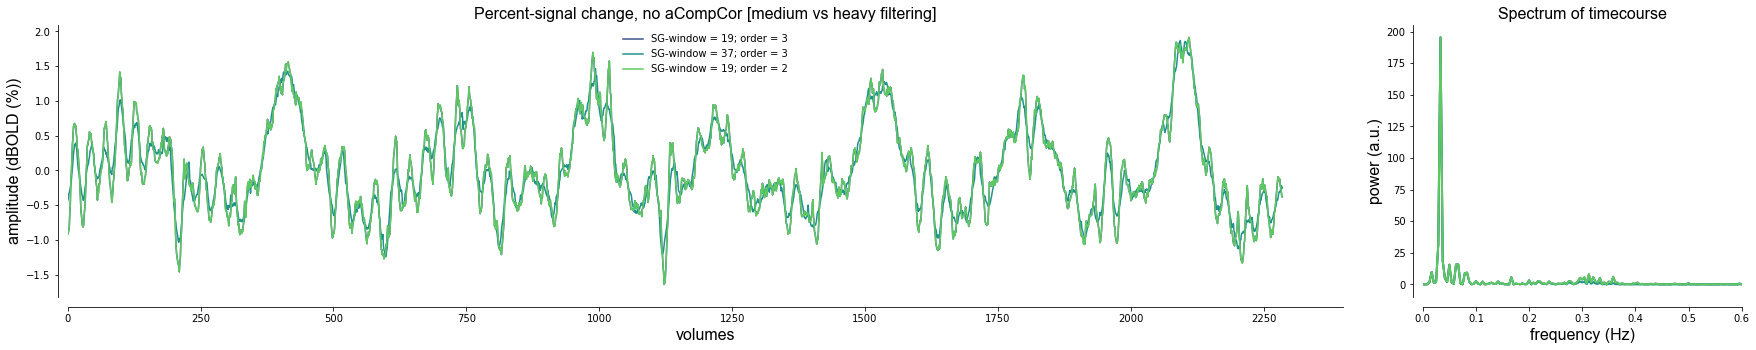

In [83]:
freq_type = "fft"
labels = ['SG-window = 19; order = 3', 'SG-window = 37; order = 3', 'SG-window = 19; order = 2']
clipper = 5
tc1 = line_psc.avg_iters_no_baseline.mean(axis=-1)
tc2 = line_psc2.avg_iters_no_baseline.mean(axis=-1)
tc3 = line_psc3.avg_iters_no_baseline.mean(axis=-1)

fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[20,5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1,tc2,tc3],
                  x_label="volumes",
                  y_label="amplitude (dBOLD (%))",
                  title="Percent-signal change, no aCompCor [medium vs heavy filtering]",
                  labels=labels,
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
tc1_freq = line_psc.get_freq(tc1, TR=0.105, spectrum_type=freq_type) #, clip_power=clipper)
# , clip_power=clipper)
tc2_freq = line_psc2.get_freq(tc2, TR=0.105, spectrum_type=freq_type)
tc3_freq = line_psc3.get_freq(tc3, TR=0.105, spectrum_type=freq_type)

plotting.LazyPlot([tc1_freq[1], tc2_freq[1], tc3_freq[1]],
                  xx=tc1_freq[0],
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0,0.6],
                  line_width=2)


The wait for PhysIO-regression continues

# Inspect individual runs

In [91]:
# run-4
run_files2 = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}", "run-4"], func_dir)
func_file2 = utils.get_file_from_substring("bold.mat", run_files2)
run4_psc = fitting.FitLines(func_files=func_file2,
                            TR=0.105,
                            low_pass=True,
                            high_pass=True,
                            window_size=11,
                            poly_order=3,
                            log_dir=log_dir,
                            stage='grid+iter',
                            model='norm',
                            baseline_duration=20,
                            iter_duration=240,
                            n_iterations=2,
                            verbose=True,
                            ribbon=ribbon,
                            ref_slice=ref)

# run-5
run_files2 = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}", "run-5"], func_dir)
func_file2 = utils.get_file_from_substring("bold.mat", run_files2)
run5_psc = fitting.FitLines(func_files=func_file2,
                            TR=0.105,
                            low_pass=True,
                            high_pass=True,
                            window_size=11,
                            poly_order=3,
                            log_dir=log_dir,
                            stage='grid+iter',
                            model='norm',
                            baseline_duration=20,
                            iter_duration=240,
                            n_iterations=2,
                            verbose=True,
                            ribbon=ribbon,
                            ref_slice=ref)
# run-6
run_files2 = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}", "run-6"], func_dir)
func_file2 = utils.get_file_from_substring("bold.mat", run_files2)
run6_psc = fitting.FitLines(func_files=func_file2,
                            TR=0.105,
                            low_pass=True,
                            high_pass=True,
                            window_size=11,
                            poly_order=3,
                            log_dir=log_dir,
                            stage='grid+iter',
                            model='norm',
                            baseline_duration=20,
                            iter_duration=240,
                            n_iterations=2,
                            verbose=True,
                            ribbon=ribbon,
                            ref_slice=ref)

tc1 = run4_psc.avg_iters_no_baseline.mean(axis=-1)
tc2 = run5_psc.avg_iters_no_baseline.mean(axis=-1)
tc3 = run6_psc.avg_iters_no_baseline.mean(axis=-1)

DATASET
Filter set to None, but low_pass+high_pass=True, setting filter to 'lowpass'

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 11, order = 3)
 Data used for percent-change: 'lowpass'

DATASET: created
Fetching dataframe from attribute 'df_func_psc'
Selecting GM-voxels: [357, 364]
Chunking/averaging iterations
 Baseline 	 = 190 vols (~19.95s) based on TR of 0.105s (20s was specified/requested)
 1 iteration 	 = 2286 vols (~240.03s) based on TR of 0.105s (240s was specified/requested)
 With baseline: (2476, 7) | No baseline: (2286, 7)
DATASET
Filter set to None, but low_pass+high_pass=True, setting filter to 'lowpass'

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-5_bold.mat
 Cut

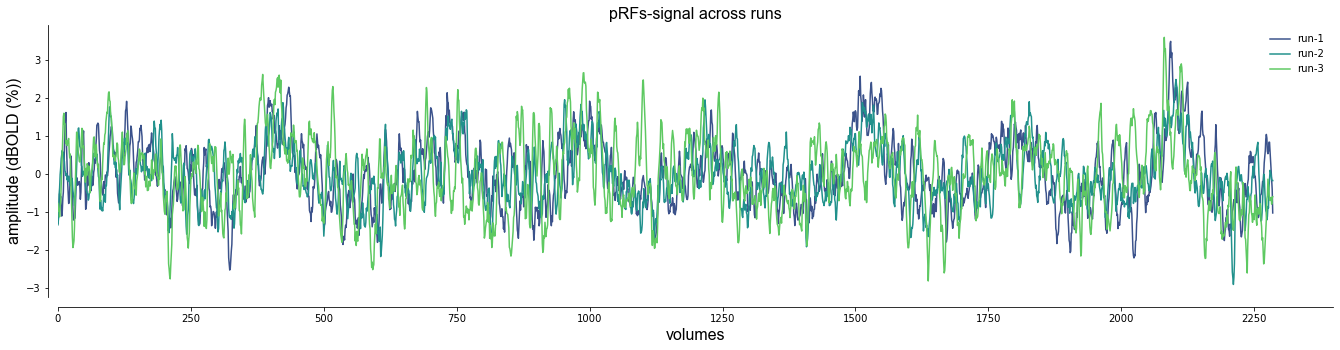

In [96]:
fig = plt.figure(figsize=(30, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[20, 5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2, tc3],
                  x_label="volumes",
                  y_label="amplitude (dBOLD (%))",
                  labels=[f"run-{ii+1}" for ii in range(3)],
                  title="pRFs-signal across runs",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)


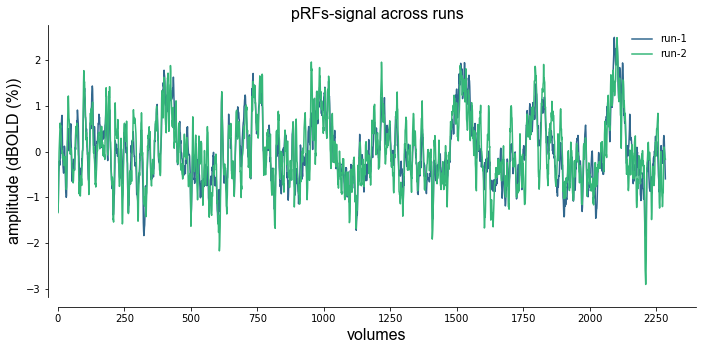

In [105]:
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[20, 5], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2],
                  x_label="volumes",
                  y_label="amplitude (dBOLD (%))",
                  labels=[f"run-{ii+1}" for ii in range(2)],
                  title="pRFs-signal across runs",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)


# Run-4/5 only

In [100]:
# run-4
run4 = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}", "run-4", "bold.mat"], func_dir)
run5 = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}", "run-5", "bold.mat"], func_dir)
funcs = [run4, run5]
run45_psc = fitting.FitLines(func_files=funcs,
                            TR=0.105,
                            low_pass=True,
                            high_pass=True,
                            window_size=11,
                            poly_order=3,
                            log_dir=log_dir,
                            stage='grid+iter',
                            model='norm',
                            baseline_duration=20,
                            iter_duration=240,
                            n_iterations=2,
                            verbose=True,
                            ribbon=ribbon,
                            ref_slice=ref)
tc1 = run45_psc.avg_iters_no_baseline.mean(axis=-1)


DATASET
Filter set to None, but low_pass+high_pass=True, setting filter to 'lowpass'

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-4_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 11, order = 3)
 Data used for percent-change: 'lowpass'
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-4/func/sub-003_ses-4_task-pRF_run-5_bold.mat
 Cutting 0 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Savitsky-Golay low pass filter [removes high frequences] (window = 11, order = 3)
 Data used for percent-change: 'lowpass'

DATASET: created
Fetching dataframe from attribute 'df_func_psc'
Selecting GM-voxels: [357, 364]
Chunking/averaging iterations
 Baseline 	 = 190 vols (~19.95s) based on TR of 0.105s (20s was specified/requested)
 1 iteration 	 = 2286 vols (

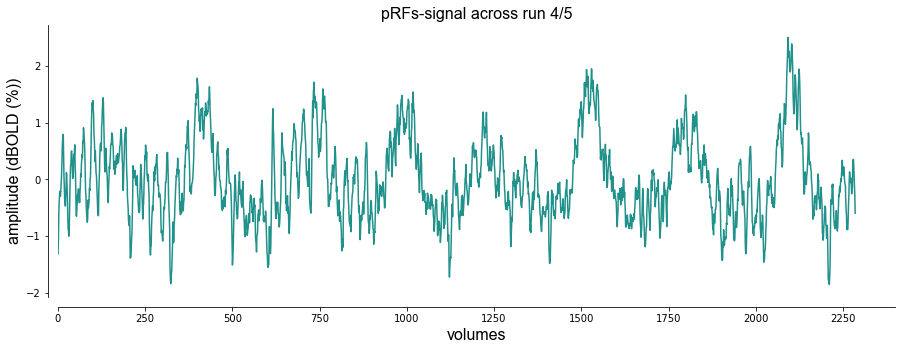

In [104]:
plotting.LazyPlot(tc1,
                  x_label="volumes",
                  y_label="amplitude (dBOLD (%))",
                  title="pRFs-signal across run 4/5",
                  font_size=16,
                  line_width=1.5,
                  figsize=(15,5))
